In [1]:
!pip install tf-agents

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import abc
import numpy as np
import tensorflow as tf

from tf_agents.agents import tf_agent
from tf_agents.drivers import driver
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.policies import tf_policy
from tf_agents.specs import array_spec
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import trajectory
from tf_agents.trajectories import policy_step
import pandas as pd
nest = tf.nest

In [3]:
class BanditPyEnvironment(py_environment.PyEnvironment):

  def __init__(self, observation_spec, action_spec):
    self._observation_spec = observation_spec
    self._action_spec = action_spec
    super(BanditPyEnvironment, self).__init__()

  # Helper functions.
  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _empty_observation(self):
    return tf.nest.map_structure(lambda x: np.zeros(x.shape, x.dtype),
                                 self.observation_spec())

  # These two functions below should not be overridden by subclasses.
  def _reset(self):
    """Returns a time step containing an observation."""
    return ts.restart(self._observe(), batch_size=self.batch_size)

  def _step(self, action):
    """Returns a time step containing the reward for the action taken."""
    reward = self._apply_action(action)
    return ts.termination(self._observe(), reward)

  # These two functions below are to be implemented in subclasses.
  @abc.abstractmethod
  def _observe(self):
    """Returns an observation."""

  @abc.abstractmethod
  def _apply_action(self, action):
    """Applies `action` to the Environment and returns the corresponding reward.
    """

In [4]:
class SimplePyEnvironment(BanditPyEnvironment):

  def __init__(self):
    action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=4, name='action')
    observation_spec = array_spec.BoundedArraySpec(
        shape=(1,), dtype=np.int32, minimum=-50, maximum=50, name='observation')
    super(SimplePyEnvironment, self).__init__(observation_spec, action_spec)

  def _observe(self):
    self._observation = np.random.randint(-50, 51, (1,), dtype='int32')
    return self._observation

  def _apply_action(self, action):
    return action * self._observation

In [5]:
environment = SimplePyEnvironment()
observation = environment.reset().observation
print("observation: %d" % observation)

action = 4 #@param

print("action: %d" % action)
reward = environment.step(action).reward
print("reward: %f" % reward)

observation: -33
action: 4
reward: -132.000000


In [6]:
import random
list_g = []
for i in range(1000):
  list_l = []
  action = random.randint(0, 4)
  reward = environment.step(action).reward
  list_l.append(i)
  list_l.append(action)
  list_l.append(reward[0])
  list_g.append(list_l)



In [7]:
list_g = np.array(list_g)

In [8]:
df = pd.DataFrame(list_g, columns =['ith trial', 'Action', 'Reward'])

In [9]:
df.head()

,ith trial,Action,Reward
0,0.0,3.0,111.0
1,1.0,0.0,0.0
2,2.0,0.0,0.0
3,3.0,3.0,-54.0
4,4.0,2.0,24.0


In [10]:
tf_environment = tf_py_environment.TFPyEnvironment(environment)

In [11]:
# Imports for example.
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.environments import stationary_stochastic_py_environment as sspe
from tf_agents.bandits.metrics import tf_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer

import matplotlib.pyplot as plt

In [12]:
observation_spec = tensor_spec.TensorSpec([4], tf.float32)
time_step_spec = ts.time_step_spec(observation_spec)
action_spec = tensor_spec.BoundedTensorSpec(dtype=tf.int32, shape=(), minimum=0, maximum=4)
agent = lin_ucb_agent.LinearUCBAgent(time_step_spec=time_step_spec,action_spec=action_spec)

In [13]:
batch_size = 2 # @param
arm0_param = [-3, 0, 1, -2] # @param
arm1_param = [1, -2, 3, 0] # @param
arm2_param = [0, 0, 1, 1] # @param
def context_sampling_fn(batch_size):
  """Contexts from [-10, 10]^4."""
  def _context_sampling_fn():
    return np.random.randint(-10, 10, [batch_size, 4]).astype(np.float32)
  return _context_sampling_fn

class LinearNormalReward(object):
  """A class that acts as linear reward function when called."""
  def __init__(self, theta, sigma):
    self.theta = theta
    self.sigma = sigma
  def __call__(self, x):
    mu = np.dot(x, self.theta)
    return np.random.normal(mu, self.sigma)

arm0_reward_fn = LinearNormalReward(arm0_param, 1)
arm1_reward_fn = LinearNormalReward(arm1_param, 1)
arm2_reward_fn = LinearNormalReward(arm2_param, 1)

environment = tf_py_environment.TFPyEnvironment(
    sspe.StationaryStochasticPyEnvironment(
        context_sampling_fn(batch_size),
        [arm0_reward_fn, arm1_reward_fn, arm2_reward_fn],
        batch_size=batch_size))


In [14]:
observation_spec = tensor_spec.TensorSpec([4], tf.float32)
time_step_spec = ts.time_step_spec(observation_spec)
action_spec = tensor_spec.BoundedTensorSpec(
    dtype=tf.int32, shape=(), minimum=0, maximum=2)

agent = lin_ucb_agent.LinearUCBAgent(time_step_spec=time_step_spec,
                                     action_spec=action_spec)

In [15]:
def compute_optimal_reward(observation):
  expected_reward_for_arms = [
      tf.linalg.matvec(observation, tf.cast(arm0_param, dtype=tf.float32)),
      tf.linalg.matvec(observation, tf.cast(arm1_param, dtype=tf.float32)),
      tf.linalg.matvec(observation, tf.cast(arm2_param, dtype=tf.float32))]
  optimal_action_reward = tf.reduce_max(expected_reward_for_arms, axis=0)
  return optimal_action_reward

regret_metric = tf_metrics.RegretMetric(compute_optimal_reward)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


Text(0.5, 0, 'Number of Iterations')

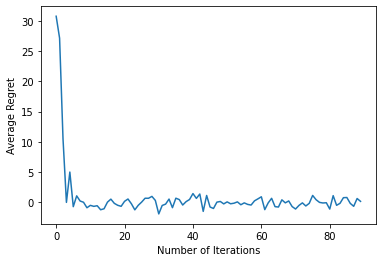

In [16]:
num_iterations = 90 # @param
steps_per_loop = 1 # @param

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=batch_size,
    max_length=steps_per_loop)

observers = [replay_buffer.add_batch, regret_metric]

driver = dynamic_step_driver.DynamicStepDriver(
    env=environment,
    policy=agent.collect_policy,
    num_steps=steps_per_loop * batch_size,
    observers=observers)

regret_values = []

for _ in range(num_iterations):
  driver.run()
  loss_info = agent.train(replay_buffer.gather_all())
  replay_buffer.clear()
  regret_values.append(regret_metric.result())

plt.plot(regret_values)
plt.ylabel('Average Regret')
plt.xlabel('Number of Iterations')